**ML Final Exam**

**Name : Haekal Rizky Yulianto**

**NIM  : 17/415900/PA/18169**

# Mulilayer Perceptron

Import required library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from random import randint
import cv2

## Data preparation

Check directory

In [2]:
import os
print(os.listdir("/Users/Haekal/Documents/ML/input"))
print(os.listdir("/Users/Haekal/Documents/ML/input/flowers/flowers"))

['.DS_Store', 'flowers']
['.DS_Store', 'daisy', 'rose', 'tulip', 'dandelion', 'sunflower']


Read Image

In [3]:
trainLabels = [] # Image label array
data = [] # Image data array

size = 320, 240 # Resize image

def readImages(flowerPath, folder):
    
    imagePaths = []
    for file in os.listdir(flowerPath):
        if file.endswith("jpg"):
            imagePaths.append(flowerPath + file)
            trainLabels.append(folder)
            img = cv2.imread((flowerPath + file), 0)
            im = cv2.resize(img, size)
            data.append(im)            
            
    return imagePaths

In [4]:
daisy_path = "/Users/Haekal/Documents/ML/input/flowers/flowers/daisy/"
rose_path = "/Users/Haekal/Documents/ML/input/flowers/flowers/rose/"
tulip_path = "/Users/Haekal/Documents/ML/input/flowers/flowers/tulip/"

Show Image

In [5]:
def showImage(imgPath):
    img = cv2.imread(imgPath)
    plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
    plt.axis('off')
    plt.show()

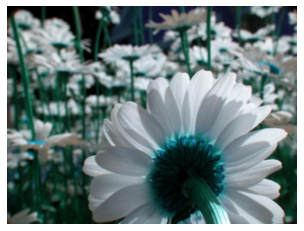

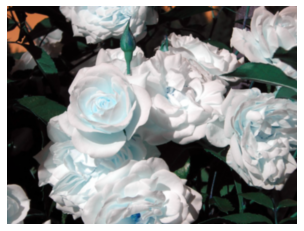

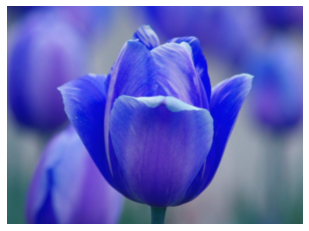

In [6]:
daisyPaths = readImages(daisy_path, 'daisy')
rosePaths = readImages(rose_path, 'rose')
tulipPaths = readImages(tulip_path, 'tulip')

showImage(daisyPaths[4]) # Example of daisy image in index 4
showImage(rosePaths[4]) # Example of rose image in index 4
showImage(tulipPaths[4]) # Example of tulip image in index 4

## Data preprocessing

Normalize image data

In [7]:
X = np.array(data)
X = X.astype('float32') / 255.0

One hot encoding for target variable

In [8]:
raw_data = {'category': trainLabels} 

In [9]:
import pandas as pd
df = pd.DataFrame(raw_data, columns = ['category'])
df

category
0      daisy
1      daisy
2      daisy
3      daisy
4      daisy
..       ...
295    tulip
296    tulip
297    tulip
298    tulip
299    tulip

[300 rows x 1 columns]

In [10]:
def to_numeric(x):
    if x == 'daisy':
        return '0'
    if x == 'rose':
        return '1'
    if x == 'tulip':
        return '2'

In [11]:
df['cat'] = df['category'].apply(to_numeric)

In [12]:
y = pd.get_dummies(df.cat, prefix='C')
y

C_0  C_1  C_2
0      1    0    0
1      1    0    0
2      1    0    0
3      1    0    0
4      1    0    0
..   ...  ...  ...
295    0    0    1
296    0    0    1
297    0    0    1
298    0    0    1
299    0    0    1

[300 rows x 3 columns]

Transform into 2D shape

In [13]:
print(X.shape)
print(y.shape)

(300, 240, 320)
(300, 3)


In [14]:
y = np.array(y)

In [15]:
X = X.reshape(X.shape[0], X.shape[1] * X.shape[2])
Y = y

In [16]:
print(X.shape)
print(Y.shape)

(300, 76800)
(300, 3)


Split the data for training and testing

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)
numberOfTrain = X_train.shape[0]
numberOfTest = X_test.shape[0]

print('Train size : ', X_train.shape[0], 'Test size : ', X_test.shape[0])

Train size :  240 Test size :  60


Transpose the data

In [18]:
X_train = X_train.T
X_test = X_test.T
Y_train = Y_train.T
Y_test = Y_test.T

In [19]:
print(X_train.shape)
print(Y_train.shape)

(76800, 240)
(3, 240)


## Model training

Declare required functions for multilayer perceptron

In [20]:
def sigmoid(z):
    s = 1. / (1. + np.exp(-z))
    return s

def compute_loss(Y, Y_hat):

    L_sum = np.sum(np.multiply(Y, np.log(Y_hat)))
    m = Y.shape[1]
    L = -(1./m) * L_sum

    return L

def feed_forward(X, params):

    cache = {}

    cache["Z1"] = np.matmul(params["W1"], X) + params["b1"]
    cache["A1"] = sigmoid(cache["Z1"]) # Sigmoid activation function
    cache["Z2"] = np.matmul(params["W2"], cache["A1"]) + params["b2"]
    cache["A2"] = np.exp(cache["Z2"]) / np.sum(np.exp(cache["Z2"]), axis=0) # Softmax activation function

    return cache

def back_propagate(X, Y, params, cache):

    dZ2 = cache["A2"] - Y
    dW2 = (1./m_batch) * np.matmul(dZ2, cache["A1"].T)
    db2 = (1./m_batch) * np.sum(dZ2, axis=1, keepdims=True)

    dA1 = np.matmul(params["W2"].T, dZ2)
    dZ1 = dA1 * sigmoid(cache["Z1"]) * (1 - sigmoid(cache["Z1"]))
    dW1 = (1./m_batch) * np.matmul(dZ1, X.T)
    db1 = (1./m_batch) * np.sum(dZ1, axis=1, keepdims=True)

    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

    return grads

Declare function to calculate accuracy

In [21]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

Training and testing

In [22]:
np.random.seed(42) # Random seed for reproducibility
m = numberOfTrain # Number of training data

# Hyperparameters
n_x = X_train.shape[0] # Number of neuron in input layer = 320 X 240 = 76800
n_h = 64 # Number of neuron in hidden layer
num_class = 3 # Number of class
learning_rate = 0.1
beta = 0.5
batch_size = 128
batches = -(-m // batch_size)

# Initialization
params = { "W1": np.random.randn(n_h, n_x) * np.sqrt(1. / n_x),
           "b1": np.zeros((n_h, 1)) * np.sqrt(1. / n_x),
           "W2": np.random.randn(num_class, n_h) * np.sqrt(1. / n_h),
           "b2": np.zeros((num_class, 1)) * np.sqrt(1. / n_h) }

V_dW1 = np.zeros(params["W1"].shape)
V_db1 = np.zeros(params["b1"].shape)
V_dW2 = np.zeros(params["W2"].shape)
V_db2 = np.zeros(params["b2"].shape)

ep = 300 # Number of epoch 
epoch = list(range(1,ep+1))
train_history = []
test_history = []
train_accuracy = []
test_accuracy = []

# Training
for i in range(ep):

    for j in range (int(batches)):
        
        begin = j * batch_size
        end = min(begin + batch_size, X_train.shape[1] - 1)
        m_batch = end - begin

        cache = feed_forward(X_train, params)
        grads = back_propagate(X_train, Y_train, params, cache)
        
        # Update parameters
        V_dW1 = (beta * V_dW1 + (1. - beta) * grads["dW1"])
        V_db1 = (beta * V_db1 + (1. - beta) * grads["db1"])
        V_dW2 = (beta * V_dW2 + (1. - beta) * grads["dW2"])
        V_db2 = (beta * V_db2 + (1. - beta) * grads["db2"])

        params["W1"] = params["W1"] - learning_rate * V_dW1
        params["b1"] = params["b1"] - learning_rate * V_db1
        params["W2"] = params["W2"] - learning_rate * V_dW2
        params["b2"] = params["b2"] - learning_rate * V_db2
    
    # Train accuracy
    cache = feed_forward(X_train, params)
    trainpredictions = np.argmax(cache["A2"], axis=0)
    trainlabels = np.argmax(Y_train, axis=0)
    train_acc = accuracy_metric(trainlabels, trainpredictions)
    train_accuracy.append(train_acc)
    
    # Train loss
    train_cost = compute_loss(Y_train, cache["A2"])
    train_history.append(train_cost)
    
    # Test accuracy
    cache = feed_forward(X_test, params)
    testpredictions = np.argmax(cache["A2"], axis=0)
    testlabels = np.argmax(Y_test, axis=0)
    test_acc = accuracy_metric(testlabels, testpredictions)
    test_accuracy.append(test_acc)
    
    # Test loss
    test_cost = compute_loss(Y_test, cache["A2"])
    test_history.append(test_cost)
    
    
    print("Epoch {}: train loss = {:.2f}, test loss = {:.2f}, train acc = {:.2f}, test acc = {:.2f}".format(i+1 ,train_cost, test_cost, train_acc, test_acc))

print("Done.")

Epoch 1: train loss = 2.61, test loss = 2.53, train acc = 32.50, test acc = 36.67
Epoch 2: train loss = 1.13, test loss = 1.17, train acc = 35.00, test acc = 26.67
Epoch 3: train loss = 1.12, test loss = 1.11, train acc = 32.50, test acc = 36.67
Epoch 4: train loss = 1.10, test loss = 1.12, train acc = 42.08, test acc = 35.00
Epoch 5: train loss = 1.08, test loss = 1.08, train acc = 34.58, test acc = 38.33
Epoch 6: train loss = 1.07, test loss = 1.09, train acc = 39.58, test acc = 31.67
Epoch 7: train loss = 1.06, test loss = 1.08, train acc = 43.33, test acc = 43.33
Epoch 8: train loss = 1.04, test loss = 1.08, train acc = 54.58, test acc = 41.67
Epoch 9: train loss = 1.03, test loss = 1.08, train acc = 55.83, test acc = 41.67
Epoch 10: train loss = 1.01, test loss = 1.08, train acc = 58.33, test acc = 45.00
Epoch 11: train loss = 1.04, test loss = 1.08, train acc = 40.83, test acc = 41.67
Epoch 12: train loss = 1.01, test loss = 1.05, train acc = 52.08, test acc = 51.67
Epoch 13: tra

Epoch 100: train loss = 1.01, test loss = 1.08, train acc = 53.75, test acc = 38.33
Epoch 101: train loss = 0.99, test loss = 1.08, train acc = 60.83, test acc = 35.00
Epoch 102: train loss = 0.97, test loss = 1.06, train acc = 66.25, test acc = 41.67
Epoch 103: train loss = 0.95, test loss = 1.11, train acc = 59.17, test acc = 30.00
Epoch 104: train loss = 0.98, test loss = 1.11, train acc = 50.42, test acc = 31.67
Epoch 105: train loss = 0.94, test loss = 1.13, train acc = 52.50, test acc = 35.00
Epoch 106: train loss = 1.01, test loss = 1.09, train acc = 50.42, test acc = 35.00
Epoch 107: train loss = 0.97, test loss = 1.06, train acc = 62.92, test acc = 43.33
Epoch 108: train loss = 1.08, test loss = 1.16, train acc = 37.92, test acc = 30.00
Epoch 109: train loss = 0.96, test loss = 1.11, train acc = 52.50, test acc = 38.33
Epoch 110: train loss = 0.98, test loss = 1.09, train acc = 50.83, test acc = 41.67
Epoch 111: train loss = 1.10, test loss = 1.22, train acc = 36.25, test acc 

Epoch 198: train loss = 0.92, test loss = 1.14, train acc = 55.42, test acc = 43.33
Epoch 199: train loss = 0.95, test loss = 1.18, train acc = 57.92, test acc = 38.33
Epoch 200: train loss = 0.99, test loss = 1.07, train acc = 42.08, test acc = 40.00
Epoch 201: train loss = 1.00, test loss = 1.21, train acc = 41.67, test acc = 28.33
Epoch 202: train loss = 0.91, test loss = 1.17, train acc = 53.33, test acc = 33.33
Epoch 203: train loss = 0.97, test loss = 1.17, train acc = 49.58, test acc = 40.00
Epoch 204: train loss = 0.94, test loss = 1.19, train acc = 53.33, test acc = 33.33
Epoch 205: train loss = 0.88, test loss = 1.11, train acc = 60.83, test acc = 43.33
Epoch 206: train loss = 0.86, test loss = 1.10, train acc = 55.42, test acc = 40.00
Epoch 207: train loss = 0.85, test loss = 1.10, train acc = 67.08, test acc = 45.00
Epoch 208: train loss = 0.89, test loss = 1.17, train acc = 64.17, test acc = 36.67
Epoch 209: train loss = 0.89, test loss = 1.10, train acc = 67.92, test acc 

Epoch 296: train loss = 1.10, test loss = 1.15, train acc = 38.33, test acc = 41.67
Epoch 297: train loss = 0.95, test loss = 1.08, train acc = 59.17, test acc = 41.67
Epoch 298: train loss = 0.99, test loss = 1.09, train acc = 51.67, test acc = 38.33
Epoch 299: train loss = 0.95, test loss = 1.12, train acc = 56.25, test acc = 33.33
Epoch 300: train loss = 1.01, test loss = 1.19, train acc = 49.17, test acc = 30.00
Done.


## Model Evaluation

Visualize loss for every epoch

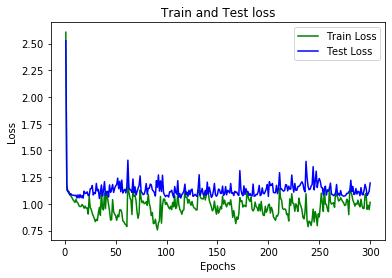

In [23]:
plt.title('Train and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epoch, train_history, 'g', label = 'Train Loss')
plt.plot(epoch, test_history, 'b', label = 'Test Loss')
plt.legend()
plt.show()

Average loss

In [24]:
import statistics

train_l = statistics.mean(train_history)
test_l = statistics.mean(test_history)
print('Average train loss = {:.2f}'.format(train_l))
print('Average test loss = {:.2f}'.format(test_l))

Average train loss = 0.98
Average test loss = 1.13


Visualize accuracy for every epoch

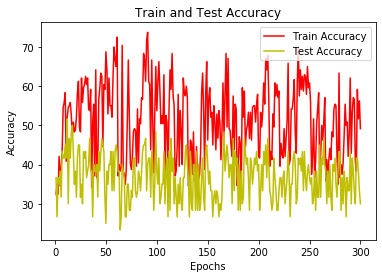

In [25]:
plt.title('Train and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epoch, train_accuracy, 'r', label = 'Train Accuracy')
plt.plot(epoch, test_accuracy, 'y', label = 'Test Accuracy')
plt.legend()
plt.show()

In [26]:
train_a = statistics.mean(train_accuracy)
test_a = statistics.mean(test_accuracy)
print('Average train accuracy = {:.2f}'.format(train_a))
print('Average test accuracy = {:.2f}'.format(test_a))

Average train accuracy = 51.29
Average test accuracy = 36.87


# Convolutional Neural Network

Import required library

In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [28]:
from sklearn.preprocessing import LabelEncoder

## Data Preparation

In [29]:
# Set the path of the input folder 
data_path = "/Users/Haekal/Documents/ML/input/flowers/flowers/"

# List out the directories inside the main input folder
folders = os.listdir(data_path)
folders.remove('.DS_Store')
folders.remove('dandelion')
folders.remove('sunflower')

print(folders)

['daisy', 'rose', 'tulip']


In [30]:
# Resize image
size1 = 320
size2 = 240

# lists to store data
data = []
label = []

for folder in folders:
    for file in os.listdir(os.path.join(data_path,folder)):
        if file.endswith("jpg"):
            img = cv2.imread(os.path.join(data_path,folder,file))
            img = cv2.resize(img, (size1,size2))
            data.append(img)
            label.append(folder)
        else:
            continue

## Data Preprocessing

Split the data for training and testing

In [31]:
# Transforming into numpy array
data = np.array(data)
label = np.array(label)

# Split dataset into train and test sets
train_data, test_data, train_label, test_label = train_test_split(data, label, test_size=0.2, random_state=42)

# Get the categories/classes
label_categories = np.unique(label)
test_label_names = test_label

One hot encoding for target/label variable

In [32]:
# Transforming object categories into numerical
encoder = LabelEncoder()

train_label = encoder.fit_transform(train_label).astype(int)
test_label = encoder.fit_transform(test_label).astype(int)

Normalize image data

In [33]:
datagen_train = ImageDataGenerator(rescale=1./255)
datagen_valid = ImageDataGenerator(rescale=1./255)

datagen_train.fit(train_data)
datagen_valid.fit(test_data)

In [34]:
test_data.shape

(60, 240, 320, 3)

In [35]:
train_data.shape

(240, 240, 320, 3)

## Model Training

Build model

In [36]:
# CNN architecture
classifier = Sequential([
    Conv2D(32, (5,5), padding='same', activation='relu', input_shape=(size2, size1,3)),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

# Visualize model summary
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 240, 320, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 120, 160, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 614400)            0         
_________________________________________________________________
dense (Dense)                (None, 32)                19660832  
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 19,663,363
Trainable params: 19,663,363
Non-trainable params: 0
_________________________________________________________________


Compile model

In [37]:
classifier.compile(optimizer='Nadam', loss='sparse_categorical_crossentropy', metrics=["accuracy"])

Train and validate model

In [38]:
history = classifier.fit(datagen_train.flow(train_data, train_label, batch_size = 128),
                         validation_data = datagen_valid.flow(test_data, test_label, batch_size = 128), 
                         epochs=300)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 2 steps, validate for 1 steps
Epoch 1/300
2/2 [==============================] - 12s 6s/step - loss: 28.7655 - accuracy: 0.3042 - val_loss: 9.3779 - val_accuracy: 0.2667
Epoch 2/300
2/2 [==============================] - 10s 5s/step - loss: 12.0539 - accuracy: 0.3417 - val_loss: 2.5022 - val_accuracy: 0.4167
Epoch 3/300
2/2 [==============================] - 9s 4s/step - loss: 3.3815 - accuracy: 0.4042 - val_loss: 1.7734 - val_accuracy: 0.4500
Epoch 4/300
2/2 [==============================] - 9s 4s/step - loss: 1.0990 - accuracy: 0.5958 - val_loss: 1.0663 - val_accuracy: 0.4833
Epoch 5/300
2/2 [==============================] - 9s 4s/step - loss: 0.7181 - accuracy: 0.6875 - val_loss: 1.1209 - val_accuracy: 0.4667
Epoch 6/300
2/2 [==============================] - 9s 4s/step - loss: 0.6384 - accuracy: 0.7125 - val_loss: 0.8903 - val_accuracy: 0.5667
Epoch 7/300
2/2 [==============================] - 9s 5s/step - loss: 0.4848 -

Epoch 116/300
2/2 [==============================] - 10s 5s/step - loss: 4.4537e-04 - accuracy: 1.0000 - val_loss: 1.3351 - val_accuracy: 0.6333
Epoch 117/300
2/2 [==============================] - 12s 6s/step - loss: 4.3094e-04 - accuracy: 1.0000 - val_loss: 1.3411 - val_accuracy: 0.6333
Epoch 118/300
2/2 [==============================] - 11s 5s/step - loss: 4.2291e-04 - accuracy: 1.0000 - val_loss: 1.3387 - val_accuracy: 0.6167
Epoch 119/300
2/2 [==============================] - 11s 5s/step - loss: 4.1381e-04 - accuracy: 1.0000 - val_loss: 1.3465 - val_accuracy: 0.6333
Epoch 120/300
2/2 [==============================] - 10s 5s/step - loss: 3.9877e-04 - accuracy: 1.0000 - val_loss: 1.3430 - val_accuracy: 0.6167
Epoch 121/300
2/2 [==============================] - 10s 5s/step - loss: 3.9493e-04 - accuracy: 1.0000 - val_loss: 1.3493 - val_accuracy: 0.6333
Epoch 122/300
2/2 [==============================] - 11s 5s/step - loss: 3.7528e-04 - accuracy: 1.0000 - val_loss: 1.3581 - val_ac

Epoch 173/300
2/2 [==============================] - 9s 4s/step - loss: 1.3733e-04 - accuracy: 1.0000 - val_loss: 1.4233 - val_accuracy: 0.6000
Epoch 174/300
2/2 [==============================] - 9s 4s/step - loss: 1.3508e-04 - accuracy: 1.0000 - val_loss: 1.4242 - val_accuracy: 0.5833
Epoch 175/300
2/2 [==============================] - 9s 4s/step - loss: 1.3345e-04 - accuracy: 1.0000 - val_loss: 1.4242 - val_accuracy: 0.5833
Epoch 176/300
2/2 [==============================] - 9s 4s/step - loss: 1.3175e-04 - accuracy: 1.0000 - val_loss: 1.4240 - val_accuracy: 0.5833
Epoch 177/300
2/2 [==============================] - 9s 4s/step - loss: 1.3033e-04 - accuracy: 1.0000 - val_loss: 1.4277 - val_accuracy: 0.6000
Epoch 178/300
2/2 [==============================] - 9s 4s/step - loss: 1.2857e-04 - accuracy: 1.0000 - val_loss: 1.4226 - val_accuracy: 0.5833
Epoch 179/300
2/2 [==============================] - 9s 4s/step - loss: 1.2783e-04 - accuracy: 1.0000 - val_loss: 1.4280 - val_accuracy:

Epoch 230/300
2/2 [==============================] - 9s 4s/step - loss: 7.3775e-05 - accuracy: 1.0000 - val_loss: 1.4810 - val_accuracy: 0.5833
Epoch 231/300
2/2 [==============================] - 9s 4s/step - loss: 7.3186e-05 - accuracy: 1.0000 - val_loss: 1.4824 - val_accuracy: 0.5833
Epoch 232/300
2/2 [==============================] - 9s 4s/step - loss: 7.2546e-05 - accuracy: 1.0000 - val_loss: 1.4838 - val_accuracy: 0.5833
Epoch 233/300
2/2 [==============================] - 9s 4s/step - loss: 7.2151e-05 - accuracy: 1.0000 - val_loss: 1.4883 - val_accuracy: 0.5833
Epoch 234/300
2/2 [==============================] - 9s 4s/step - loss: 7.1421e-05 - accuracy: 1.0000 - val_loss: 1.4878 - val_accuracy: 0.5833
Epoch 235/300
2/2 [==============================] - 9s 4s/step - loss: 7.0873e-05 - accuracy: 1.0000 - val_loss: 1.4872 - val_accuracy: 0.5833
Epoch 236/300
2/2 [==============================] - 9s 4s/step - loss: 7.0258e-05 - accuracy: 1.0000 - val_loss: 1.4889 - val_accuracy:

Epoch 287/300
2/2 [==============================] - 9s 4s/step - loss: 4.8760e-05 - accuracy: 1.0000 - val_loss: 1.5368 - val_accuracy: 0.5833
Epoch 288/300
2/2 [==============================] - 9s 4s/step - loss: 4.8372e-05 - accuracy: 1.0000 - val_loss: 1.5370 - val_accuracy: 0.5833
Epoch 289/300
2/2 [==============================] - 9s 4s/step - loss: 4.8106e-05 - accuracy: 1.0000 - val_loss: 1.5375 - val_accuracy: 0.5833
Epoch 290/300
2/2 [==============================] - 9s 4s/step - loss: 4.7757e-05 - accuracy: 1.0000 - val_loss: 1.5390 - val_accuracy: 0.5833
Epoch 291/300
2/2 [==============================] - 9s 5s/step - loss: 4.7444e-05 - accuracy: 1.0000 - val_loss: 1.5389 - val_accuracy: 0.5833
Epoch 292/300
2/2 [==============================] - 9s 5s/step - loss: 4.7189e-05 - accuracy: 1.0000 - val_loss: 1.5394 - val_accuracy: 0.5833
Epoch 293/300
2/2 [==============================] - 9s 5s/step - loss: 4.6855e-05 - accuracy: 1.0000 - val_loss: 1.5403 - val_accuracy:

## Model Evaluation

Visualize training and validation accuracy/loss

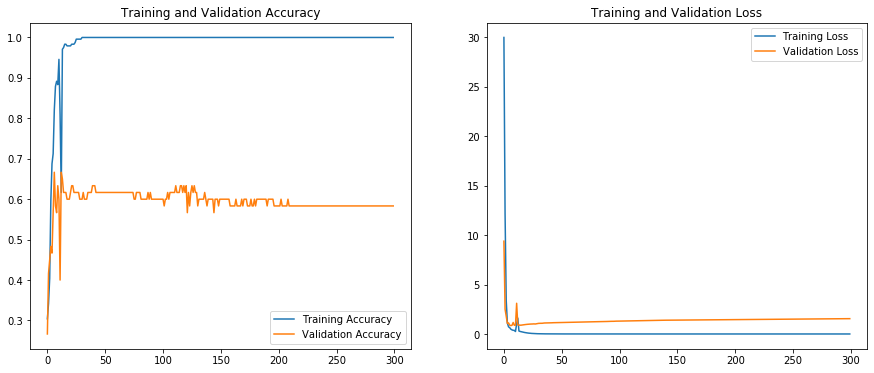

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(300)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [40]:
print('Average training accuracy : ', statistics.mean(history.history['accuracy']))
print('Average validation accuracy : ', statistics.mean(history.history['val_accuracy']), '\n')

print('Average training loss : ', statistics.mean(history.history['loss']))
print('Average validation loss : ', statistics.mean(history.history['val_loss']))

Average training accuracy :  0.9854583
Average validation accuracy :  0.5948333 

Average training loss :  0.18273056003539062
Average validation loss :  1.3833704330523808


Visualize classifications example

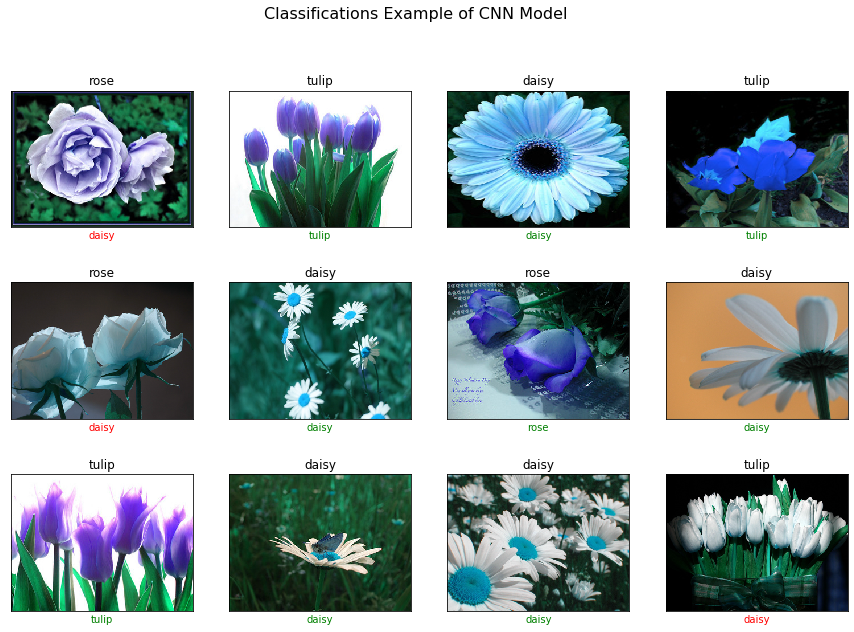

In [41]:
fig = plt.figure(figsize=(15,10))
fig.suptitle("Classifications Example of CNN Model", fontsize=16)

predictions = classifier.predict(test_data)
predictions = np.argmax(predictions, axis=1)

for i in range(12):
    number = randint(0, len(predictions))
    plt.subplot(3,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(test_label_names[number])
    plt.imshow(test_data[number], cmap=plt.cm.binary)
    if test_label_names[number] == label_categories[predictions[number]]:
        plt.xlabel(label_categories[predictions[number]], color='green')
    else:
        plt.xlabel(label_categories[predictions[number]], color='red')
plt.show()

# Final words

**Data :**

The data consist of 300 images : 100 images each for Daisy, Rose and Tulip

300 images randomly divided into 240 images for training and 60 images for testing

**Architecture and Evaluation:**

A Multilayer Perceptron (MLP) model with 1 hidden layer architecture produces a faster classification result with ~51% accuracy for training and ~37% accuracy for testing, ~1.0 loss for both training and ~1.1 loss for testing.

Convolutional Neural Network (CNN) model with 1 pair of Conv-Pool layers and 1 hidden layer architecture produces a longer classification result with ~98% accuracy for training and ~59% accuracy for validation, ~0.2 loss for training and ~1.4 loss for validation.

**Conclusion :**

MLPs use one perceptron for each input (e.g pixel) and the amount of weights rapidly becomes unmanageable for large images. One of the common problems is that MLPs react differently to an input (images) and its shifted version. For example in this data, the flower is not always in the same position on every image and MLPs will try to correct itself and assume that the objects will always appear in certain sections of the image. In this MLPs model architecture, both loss and accuracy are fluctuating as the model seems to be confused on what makes which images belong to which flower class, since MLP doesn't have feature extraction layer(s). 

This CNN architecture successfully distinguishes the training images well (too well), but cannot generalize well in the validation images. Overfitting happens in the CNN architecture because the amount of data is too small (only 300 data in total), there are no image augmentation and dropout layer(s) or regularization(L1/L2) applied in this CNN architecture model.

Configuring a deeper layer in CNN model architecture with more than one Conv-Pool layers, applying image augmentation, using dropout layer(s), and feeding more training data will probably increase the accuracy and also avoid overfitting.